In [3]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 60.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

In [9]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

dataloader_train = DataLoader(train_data, batch_size=30, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=30, shuffle=True)

torch.Size([28, 28])


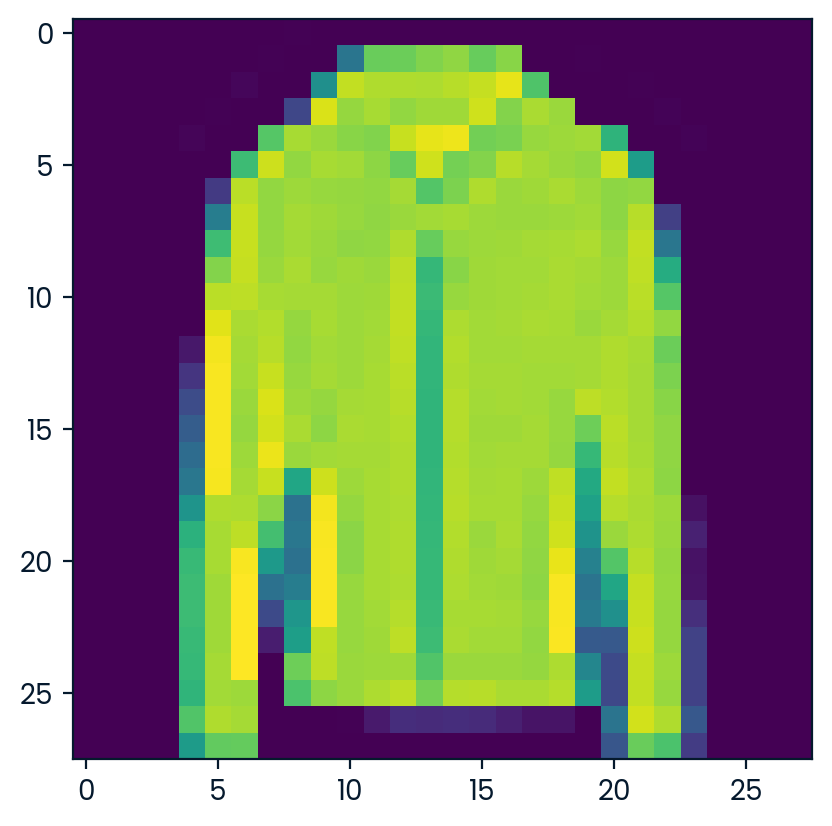

In [42]:
# Show an example of what the model will be processing
import matplotlib.pyplot as plt

img, label = next(iter(dataloader_train))
img = img.squeeze()
print(img.shape)

plt.imshow(img)
plt.show()

In [13]:
# Define the CNN model we will be using
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.lin_layer = nn.Linear(1568, num_classes)
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.lin_layer(x)
        return x

In [14]:
# Initialize the model and set the loss and optimizer functions
model = CNNClassifier(num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [15]:
# Run the training loop
for epoch in range(5):
    sum_loss = 0.0
    for img, label in dataloader_train:
        optimizer.zero_grad()
        img_pred = model(img)
        loss = loss_fn(img_pred, label)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() 
        
    avg_loss = sum_loss / len(dataloader_train)
    print(f'Epoch: {epoch + 1}\nLoss: {avg_loss:.4f}')

Epoch: 1
Loss: 0.3739
Epoch: 2
Loss: 0.2707
Epoch: 3
Loss: 0.2369
Epoch: 4
Loss: 0.2155
Epoch: 5
Loss: 0.1997


In [28]:
# Set our evaluation methods
metric_accuracy = Accuracy(task='multiclass', num_classes=10)
metric_precision = Precision(task='multiclass', num_classes=10, average=None)
metric_recall = Recall(task='multiclass', num_classes=10, average=None)
predictions = []

# Test and evaluate the model
model.eval()
for img, label in dataloader_test:
    output = model(img)
    _, pred = torch.max(output, 1)
    predictions.append(pred)
    metric_accuracy(pred, label)
    metric_precision(pred, label)
    metric_recall(pred, label)
    
# Compute metrics
classes = train_data.classes
accuracy = metric_accuracy.compute().item()
precision = metric_precision.compute().tolist()
recall = metric_recall.compute().tolist()

precision_classes = {classes[i]: precision[i] for i in range(len(classes))}
recall_classes = {classes[i]: recall[i] for i in range(len(classes))}

print('Accuracy: ', accuracy)
print('Precision: \n', precision_classes)
print('Recall: \n', recall_classes)

Accuracy:  0.9107999801635742
Precision: 
 {'T-shirt/top': 0.8068181872367859, 'Trouser': 0.9850000143051147, 'Pullover': 0.8763102889060974, 'Dress': 0.9199594855308533, 'Coat': 0.7963917255401611, 'Sandal': 0.9898062944412231, 'Shirt': 0.8409387469291687, 'Sneaker': 0.9582089781761169, 'Bag': 0.9969325065612793, 'Ankle boot': 0.9558823704719543}
Recall: 
 {'T-shirt/top': 0.9229999780654907, 'Trouser': 0.9850000143051147, 'Pullover': 0.8360000252723694, 'Dress': 0.9079999923706055, 'Coat': 0.9269999861717224, 'Sandal': 0.9710000157356262, 'Shirt': 0.6449999809265137, 'Sneaker': 0.9629999995231628, 'Bag': 0.9750000238418579, 'Ankle boot': 0.9750000238418579}
